In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import kagglehub

path = kagglehub.dataset_download("ninadaithal/imagesoasis")
print("/content/OASIS_LOCAL", path)



100%|██████████| 1.23G/1.23G [00:41<00:00, 31.5MB/s]

Extracting files...


/content/OASIS_LOCAL /root/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import torchvision.models as models
from tqdm import tqdm

MRI_ROOT = "/root/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data"

data_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

OASIS = datasets.ImageFolder(root=MRI_ROOT, transform=data_tf)

print("Classes:", OASIS.classes)
print("Total images:", len(OASIS))


Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Total images: 86437


In [ ]:
indices = list(range(len(OASIS)))
subset = indices[: int(len(indices) * 0.25)]

train_idx, val_idx = train_test_split(subset, test_size=0.2, shuffle=True)

train_loader = DataLoader(Subset(OASIS, train_idx), batch_size=32, shuffle=True)
val_loader   = DataLoader(Subset(OASIS, val_idx), batch_size=32, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 541
Val batches: 136


In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


In [ ]:
def train_resnet(model, train_loader, val_loader, epochs=2):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x,y in tqdm(train_loader):
            x,y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1} TrainLoss={total_loss/len(train_loader):.4f}")

train_resnet(model, train_loader, val_loader, epochs=2)


100%|██████████| 541/541 [1:13:09<00:00,  8.11s/it]


Epoch 1 TrainLoss=0.0922


100%|██████████| 541/541 [1:12:14<00:00,  8.01s/it]

Epoch 2 TrainLoss=0.0098


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x,y in val_loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y.numpy())

# ---- Fix: detect which classes are actually present ----
labels_unique = sorted(list(set(all_labels)))

print("Present classes:", [OASIS.classes[i] for i in labels_unique])
print()

print(classification_report(
    all_labels,
    all_preds,
    labels=labels_unique,
    target_names=[OASIS.classes[i] for i in labels_unique]
))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds, labels=labels_unique))


Present classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented']

                   precision    recall  f1-score   support

    Mild Dementia       0.98      1.00      0.99       946
Moderate Dementia       1.00      1.00      1.00        93
     Non Demented       1.00      0.99      1.00      3283

         accuracy                           1.00      4322
        macro avg       0.99      1.00      1.00      4322
     weighted avg       1.00      1.00      1.00      4322

Confusion Matrix:
[[ 944    0    2]
 [   0   93    0]
 [  18    0 3265]]


In [ ]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()

        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x):
        logits = self.model(x)

        class_idx = logits.argmax(dim=1)
        score = logits[:, class_idx]

        self.model.zero_grad()
        score.backward(torch.ones_like(score))

        gradients = self.gradients
        activations = self.activations

        weights = gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * activations).sum(dim=1)

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        cam = F.interpolate(
            cam.unsqueeze(1),
            size=(224, 224),
            mode="bilinear",
            align_corners=False
        )

        return cam.squeeze().cpu().numpy(), class_idx.cpu().numpy()


In [ ]:
def show_gradcam(img_tensor, cam, true_label, pred_label):
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = (img - img.min()) / (img.max() + 1e-6)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    overlay = heatmap * 0.4 + img

    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.title(f"Input | True: {true_label}")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title(f"Grad-CAM | Pred: {pred_label}")
    plt.imshow(overlay)
    plt.axis("off")

    plt.show()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


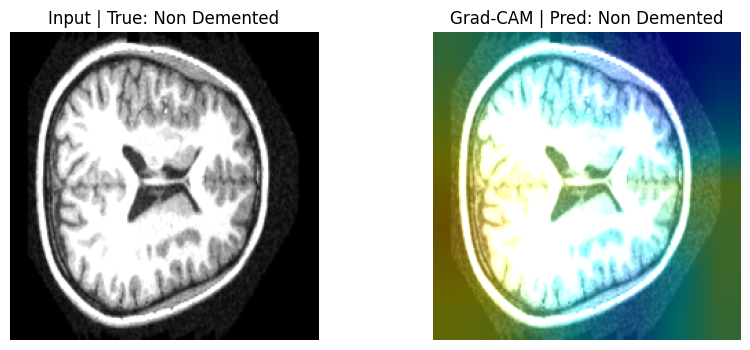

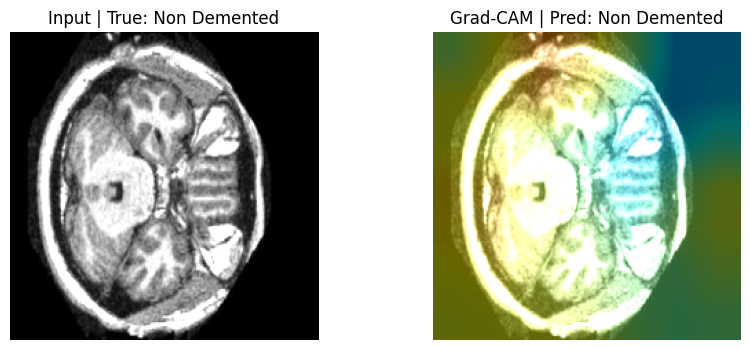

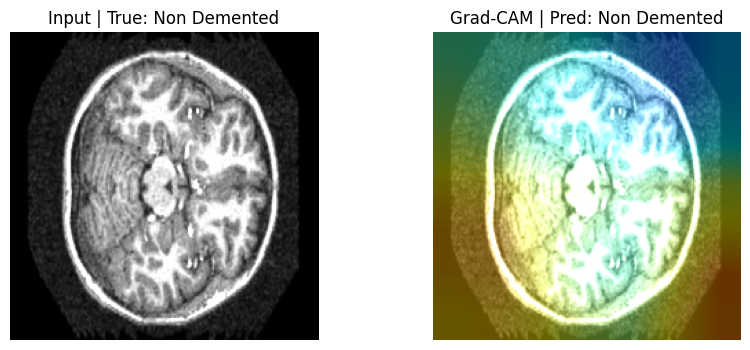

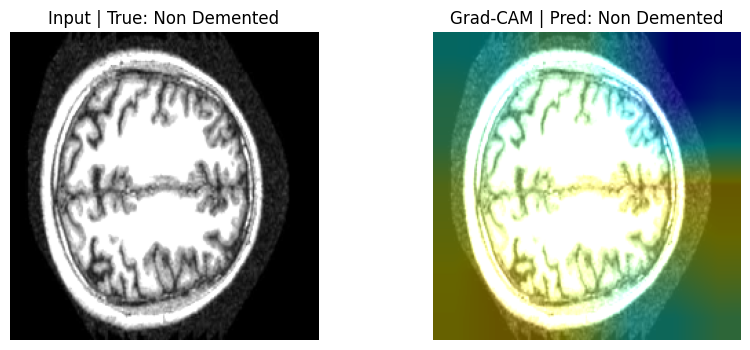

In [ ]:
layer = model.layer4[-1]   # last conv block
cam = GradCAM(model, layer)

model.eval()

images, labels = next(iter(val_loader))
images = images.to(device)

cams, preds = cam(images)

for i in range(4):   # show first 4 images
    show_gradcam(
        images[i].cpu(),
        cams[i],
        true_label=OASIS.classes[labels[i]],
        pred_label=OASIS.classes[preds[i]]
    )


In [ ]:
torch.save(model.state_dict(), "oasis_resnet_model.pth")


In [ ]:
from torchvision import datasets, transforms

MRI_ROOT = "/root/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data"

data_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

OASIS = datasets.ImageFolder(
    root=MRI_ROOT,
    transform=data_tf
)


FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data'